In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import Orange
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

In [384]:
# os.walk of new name
folder_path = r'C:\Users\Anak\PycharmProjects\recreate_gene_disease\PerformanceResult\LinkPrediction\GeneDiseaseProject\copd\PhenotypeGeneDisease'

def get_auc_val(folder_n, file_n):
    performance_path = folder_n + '\\' + file_n
    # print(performance_path)
    import pandas as pd
#     print(performance_path)
    result = pd.read_csv(performance_path)
    # print(folder_n)
    # print(file_n)
#     print(result)
    auc = result.iloc[2]['AUC']
    return auc

def get_strategy_name(file_name, strategy_name):
    for ind, t in enumerate(file_name[1:]):
        if t == 'dim64':
            break
        strategy_name.append(t)
    return strategy_name

def walk_folder():
#     records = []
#     class_embedding_dict = {}
#     qualified_node_strategy = {}
#     embedding_qualified_nodes = {}
#     strategy_th = {}
    all_record = []
    for i,j,k in os.walk(folder_path, topdown=False):
        if len(k) > 0 :

            x = i.split('\\')
            graph_type = x[-8]
            classifier = x[-7]
            embedding = x[-6]
            qualified_node = x[-3]
            
            
#             if classifier is not None:
            

#                 print(x)
#                 print(j)
#                 print(k)

            folder_name = '_'.join([classifier, embedding, qualified_node])
            folder_name = folder_name # folder where list of file exists


            for file in k:
                file_name = file.split('_')
                strategy_name = []

                if file_name[0] == 'train':
#                     if file_name[0] == 'train':
                    streategy_name = get_strategy_name(file_name, strategy_name)
#                         print(folder_name)
#                         print(strategy_name)
                    suffix, th = strategy_name[-1].split('=')
                    if len(th.split('.')) > 2:
#                             print(th)
                        th = th.split('.')[:-1]
                        th = '.'.join(th)
                    strategy_name = strategy_name[:-1] + [suffix]
                    strategy_name = '_'.join(strategy_name)
#                         print(th)
#                         print(strategy_name)

                    if float(th) in [0.05, 0.1 ,0.4,0.5]:
                        auc = get_auc_val(i, file)

                        dict_per_record = {}
                        dict_per_record['th'] = th
                        dict_per_record['qualified_nodes'] = qualified_node
                        dict_per_record['embedding'] = embedding
                        dict_per_record['strategy'] = strategy_name
                        dict_per_record['classifier'] = classifier
                        dict_per_record['graph_type'] = graph_type
                        dict_per_record['auc'] = auc
#                             if file == "train_top_bottom_k_deterministic=0.4_dim64_walk_len30_num_walks200_window10.txt":
#                                 print(auc)

#                             print(auc)
#                             print(id(dict_per_record))
#                             print(len(all_record))
                        all_record.append(dict_per_record)
#                             print(strategy_th)
#                             if strategy_name not in strategy_th:
#                                 strategy_th[strategy_name] = {}
#                                 if th not in strategy_th[strategy_name]:
#                                     strategy_th[strategy_name][th] = auc
#                             else:
#                                 if th not in strategy_th[strategy_name]:
#                                     strategy_th[strategy_name][th] = auc


#                 qualified_node_strategy.setdefault(qualified_node, {}).update(strategy_th)

#                 embedding_qualified_nodes.setdefault(embedding, {}).update(qualified_node_strategy)
#             class_embedding_dict.setdefault(classifier, {}).update(embedding_qualified_nodes)
#     return class_embedding_dict
    return all_record


In [385]:
class_embedding_dict = walk_folder()
print(len(class_embedding_dict))

576


# Create all recorder

### clean data

In [386]:
import pandas as pd
all_record_pd = pd.DataFrame(class_embedding_dict)


In [387]:
get_unique_val(all_record_pd, 'strategy')

array(['all', 'all_nodes_random', 'bottom', 'bottom_k_deterministic',
       'bottom_k_random', 'bottom_rand', 'shared', 'shared_nodes_random',
       'top', 'top_bottom', 'top_bottom_k_deterministic',
       'top_bottom_k_random', 'top_bottom_rand', 'top_k', 'top_k_random',
       'top_rand'], dtype=object)

In [388]:

all_record_pd.loc[all_record_pd['strategy'] == 'bottom_k_deterministic', 'strategy'] = 'bottom'
all_record_pd.loc[all_record_pd['strategy'] == 'bottom_k_random', 'strategy'] = 'bottom_rand'
all_record_pd.loc[all_record_pd['strategy'] == 'top_bottom_k_deterministic', 'strategy'] = 'top_bottom'
all_record_pd.loc[all_record_pd['strategy'] == 'top_bottom_k_random', 'strategy'] = 'top_bottom_rand'
all_record_pd.loc[all_record_pd['strategy'] == 'top_k', 'strategy'] = 'top'
all_record_pd.loc[all_record_pd['strategy'] == 'top_k_random', 'strategy'] = 'top_rand'
all_record_pd.loc[all_record_pd['strategy'] == 'all_nodes_random', 'strategy'] = 'all'
all_record_pd.loc[all_record_pd['strategy'] == 'shared_nodes_random', 'strategy'] = 'shared'

# Define functions

In [7]:
def get_unique_val(x, val):
    return np.unique(x[val].to_numpy())
    

In [8]:
get_unique_val(all_record_pd, 'graph_type')

array(['PGD', 'PGDP'], dtype=object)

In [9]:
def groupby_list_of_val(df, list_of_val):
    return df.groupby(list_of_val)

In [10]:
def run_friedman_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
            
    print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        stat, p = friedmanchisquare(*[k[1] for k in val])
        
        print(f'--------for {i}----')
#         print([k[0] for k in val])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution')
        else:
            print('Probably different distributions')

In [11]:
def run_nemenyi_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
    #     print(key)

#     print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        block_per_row = np.array([k[1] for k in val]).T
        arg_sort_block = np.flip(np.argsort(block_per_row, axis=1, ),-1)
#         print(block_per_row)
#         print(f'======={i}==========')
        def get_rank(y):
            tmp = []
            for j in range(y.shape[0]):
    #             print([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
                tmp.append([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
            return np.array(tmp)
    #     print(get_rank(arg_sort_block))
        def get_avg_rank_per_block(y):
            return y.sum(axis=0)/y.shape[0]
#         print(arg_sort_block.sum(axis=0))
#         print([k[0] for k in val])
#         print(get_avg_rank_per_block(get_rank(arg_sort_block)))
        def plot_cd(avranks, n, names):
            cd = Orange.evaluation.compute_CD(avranks, 30) #tested on 30 datasets
            Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
            plt.show()
        col_names = [v[0] for v in val]
        plot_cd(get_avg_rank_per_block(get_rank(arg_sort_block)), arg_sort_block.shape[0], col_names)
    

# Plot Critical Difference


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
--------for 0.05----
stat=5.238, p=0.388
Probably the same distribution
--------for 0.1----
stat=15.000, p=0.010
Probably different distributions
--------for 0.4----
stat=2.976, p=0.704
Probably the same distribution
--------for 0.5----
stat=5.131, p=0.400
Probably the same distribution
--------for no----
stat=nan, p=nan
Probably different distributions


c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:6668: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


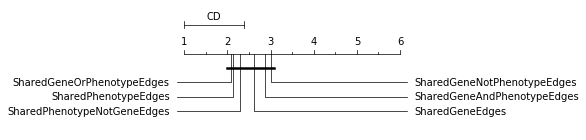

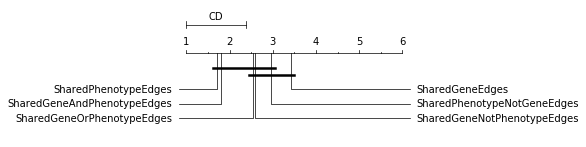

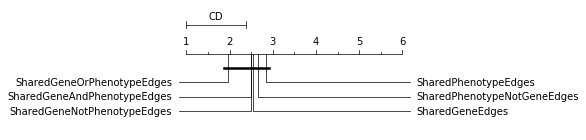

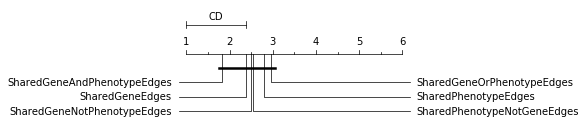

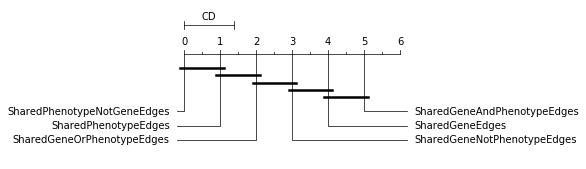


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
--------for 0.05----
stat=4.714, p=0.452
Probably the same distribution
--------for 0.1----
stat=9.595, p=0.088
Probably the same distribution
--------for 0.4----
stat=9.262, p=0.099
Probably the same distribution
--------for 0.5----
stat=7.286, p=0.200
Probably the same distribution
--------for no----
stat=nan, p=nan
Probably different distributions


c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:6668: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


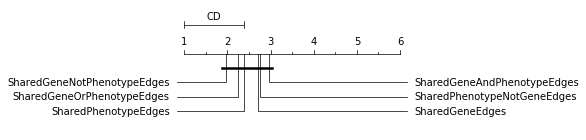

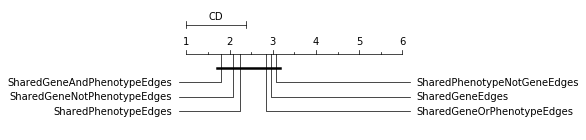

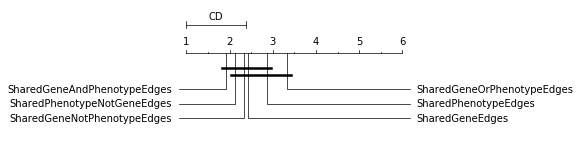

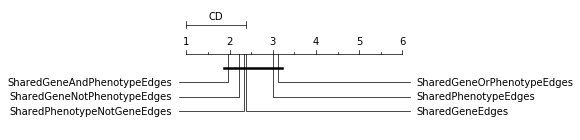

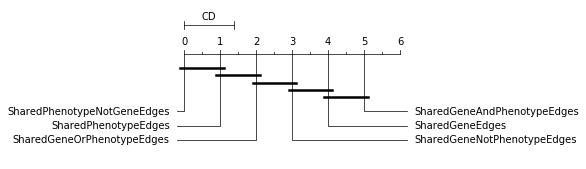


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
--------for 0.05----
stat=6.778, p=0.452
Probably the same distribution
--------for 0.1----
stat=12.204, p=0.094
Probably the same distribution
--------for 0.4----
stat=6.333, p=0.501
Probably the same distribution
--------for 0.5----
stat=10.296, p=0.172
Probably the same distribution
--------for no----
stat=nan, p=nan
Probably different distributions


c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:6668: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


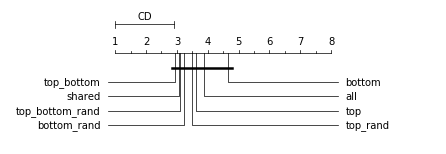

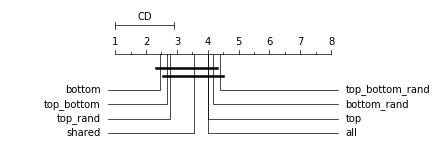

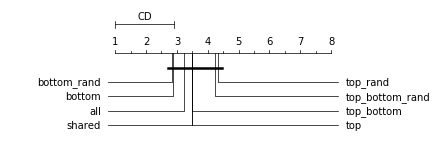

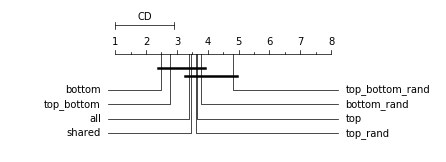

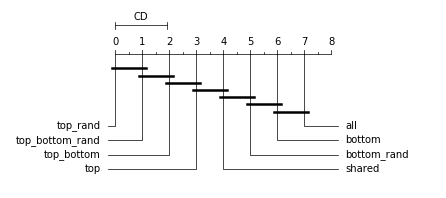


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
--------for 0.05----
stat=4.852, p=0.678
Probably the same distribution
--------for 0.1----
stat=26.704, p=0.000
Probably different distributions
--------for 0.4----
stat=11.889, p=0.104
Probably the same distribution
--------for 0.5----
stat=18.704, p=0.009
Probably different distributions
--------for no----
stat=nan, p=nan
Probably different distributions


c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:6668: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\anak\anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


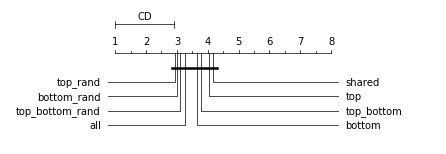

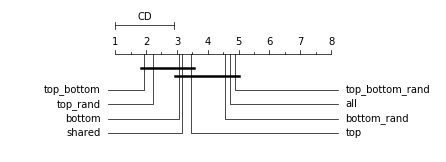

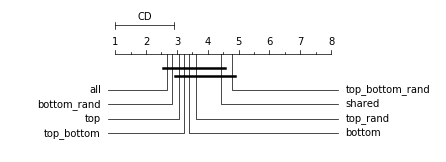

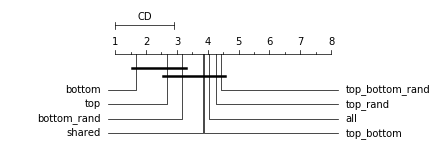

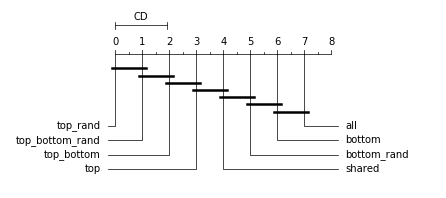


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
--------for 0.05----
stat=15.500, p=0.000
Probably different distributions
--------for 0.1----
stat=15.167, p=0.001
Probably different distributions
--------for 0.4----
stat=12.667, p=0.002
Probably different distributions
--------for 0.5----
stat=9.042, p=0.011
Probably different distributions
--------for no----
stat=96.000, p=0.000
Probably different distributions


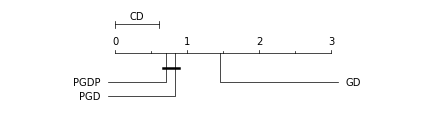

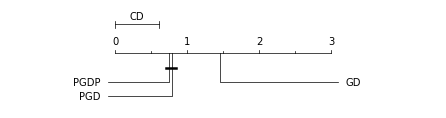

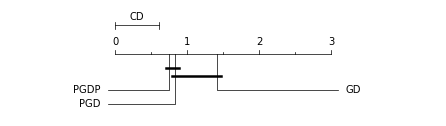

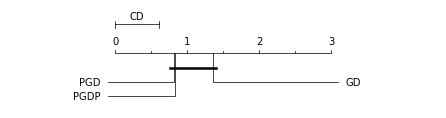

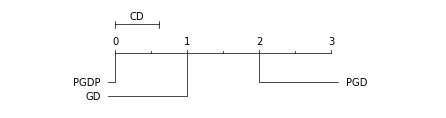


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
--------for 0.05----
stat=21.125, p=0.000
Probably different distributions
--------for 0.1----
stat=17.792, p=0.000
Probably different distributions
--------for 0.4----
stat=2.000, p=0.368
Probably the same distribution
--------for 0.5----
stat=19.292, p=0.000
Probably different distributions
--------for no----
stat=96.000, p=0.000
Probably different distributions


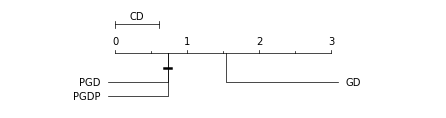

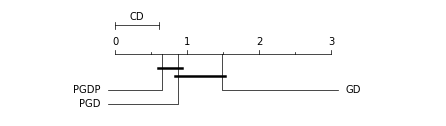

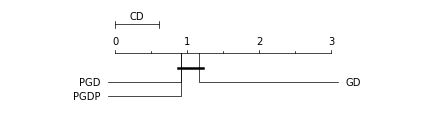

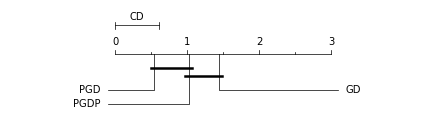

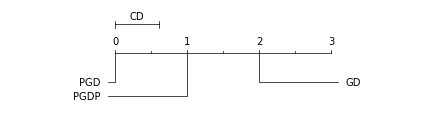

In [512]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
# block_list = ['th']
# block_list = ['qualified_nodes']
# block_list = ['strategy']
# block_list = ['embedding']
# block_list = ['graph_type']

embedding_types = ['Node2Vec', 'GCN']
group = 'th'

count = 0
for i in block_list:
    for j in embedding_types:
        count += 1
        if i != group and i!='embedding':
            print()
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
#                 run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
                run_friedman_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
#             run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
#             try:
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
#             except: 
#                 print('skip')

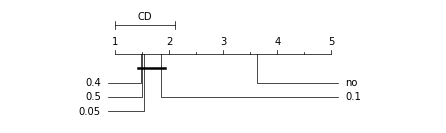

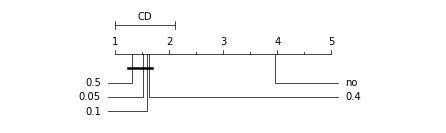

In [513]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'th']
embedding_types = ['Node2Vec', 'GCN']
group = 'embedding'

for i in block_list:
    if i != group:
        run_nemenyi_test(test_all_record_7, group, i )
            


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = th
--------for SharedGeneAndPhenotypeEdges----
stat=52.534, p=0.000
Probably different distributions
--------for SharedGeneEdges----
stat=48.426, p=0.000
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=45.804, p=0.000
Probably different distributions
--------for SharedGeneOrPhenotypeEdges----
stat=46.823, p=0.000
Probably different distributions
--------for SharedPhenotypeEdges----
stat=49.545, p=0.000
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=49.200, p=0.000
Probably different distributions


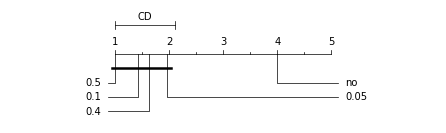

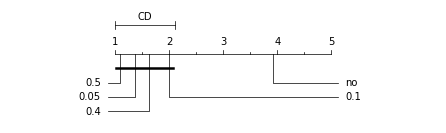

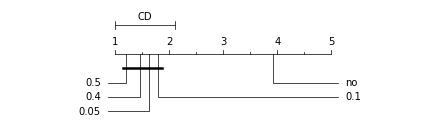

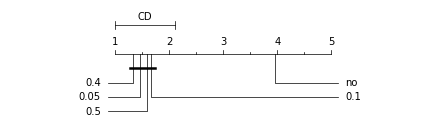

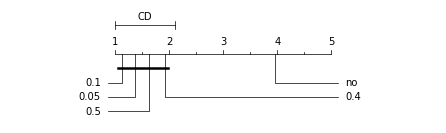

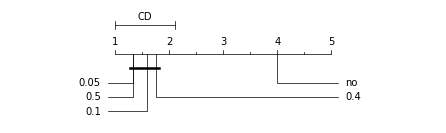


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = th
--------for SharedGeneAndPhenotypeEdges----
stat=40.233, p=0.000
Probably different distributions
--------for SharedGeneEdges----
stat=33.433, p=0.000
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=31.967, p=0.000
Probably different distributions
--------for SharedGeneOrPhenotypeEdges----
stat=39.033, p=0.000
Probably different distributions
--------for SharedPhenotypeEdges----
stat=29.067, p=0.000
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=37.100, p=0.000
Probably different distributions


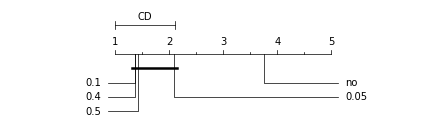

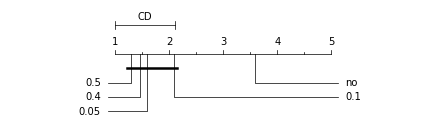

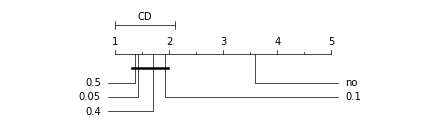

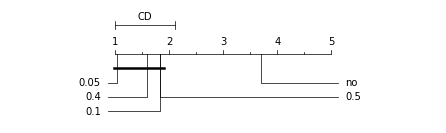

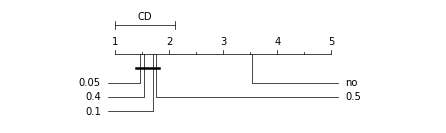

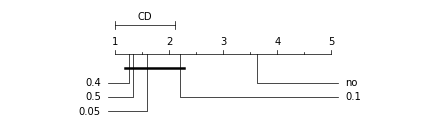


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = strategy
--------for SharedGeneAndPhenotypeEdges----
stat=9.583, p=0.213
Probably the same distribution
--------for SharedGeneEdges----
stat=11.056, p=0.136
Probably the same distribution
--------for SharedGeneNotPhenotypeEdges----
stat=6.611, p=0.470
Probably the same distribution
--------for SharedGeneOrPhenotypeEdges----
stat=10.333, p=0.170
Probably the same distribution
--------for SharedPhenotypeEdges----
stat=8.333, p=0.304
Probably the same distribution
--------for SharedPhenotypeNotGeneEdges----
stat=7.194, p=0.409
Probably the same distribution


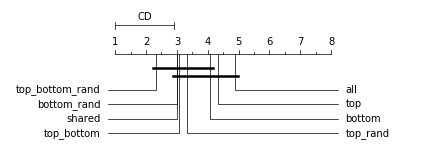

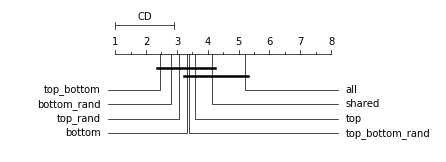

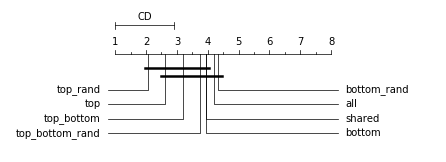

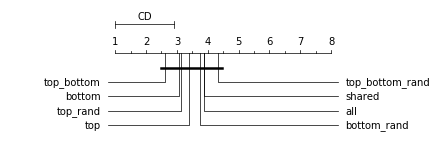

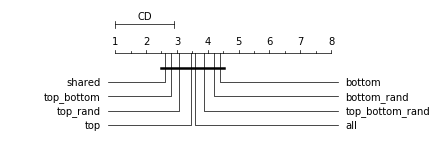

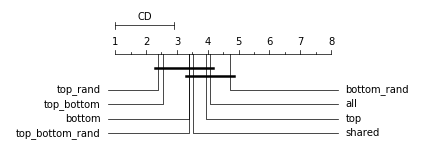


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = strategy
--------for SharedGeneAndPhenotypeEdges----
stat=13.556, p=0.060
Probably the same distribution
--------for SharedGeneEdges----
stat=12.889, p=0.075
Probably the same distribution
--------for SharedGeneNotPhenotypeEdges----
stat=18.306, p=0.011
Probably different distributions
--------for SharedGeneOrPhenotypeEdges----
stat=9.972, p=0.190
Probably the same distribution
--------for SharedPhenotypeEdges----
stat=6.972, p=0.432
Probably the same distribution
--------for SharedPhenotypeNotGeneEdges----
stat=10.944, p=0.141
Probably the same distribution


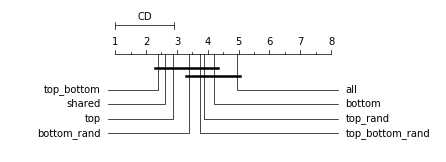

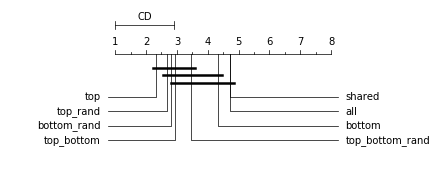

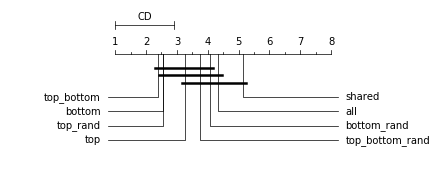

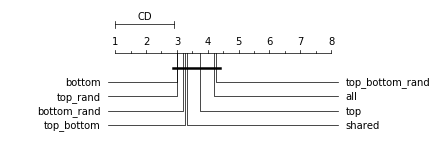

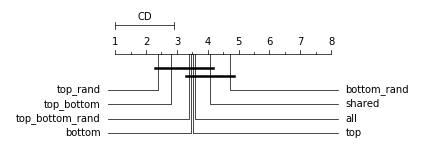

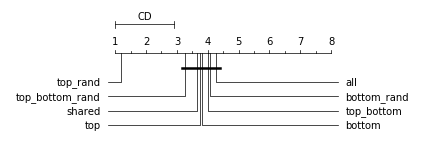


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = graph_type
--------for SharedGeneAndPhenotypeEdges----
stat=10.850, p=0.004
Probably different distributions
--------for SharedGeneEdges----
stat=9.150, p=0.010
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=9.950, p=0.007
Probably different distributions
--------for SharedGeneOrPhenotypeEdges----
stat=10.400, p=0.006
Probably different distributions
--------for SharedPhenotypeEdges----
stat=9.950, p=0.007
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=18.350, p=0.000
Probably different distributions


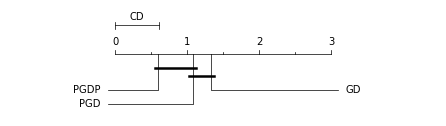

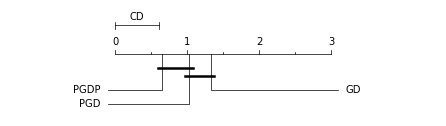

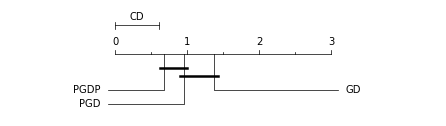

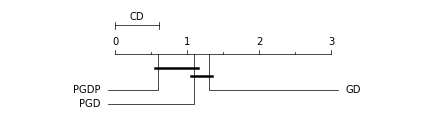

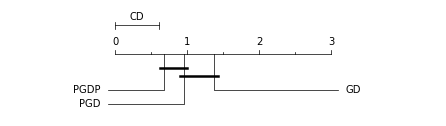

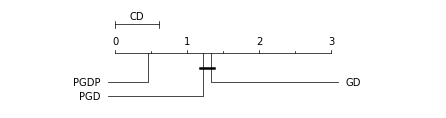


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = graph_type
--------for SharedGeneAndPhenotypeEdges----
stat=17.150, p=0.000
Probably different distributions
--------for SharedGeneEdges----
stat=20.600, p=0.000
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=23.400, p=0.000
Probably different distributions
--------for SharedGeneOrPhenotypeEdges----
stat=18.200, p=0.000
Probably different distributions
--------for SharedPhenotypeEdges----
stat=13.400, p=0.001
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=19.950, p=0.000
Probably different distributions


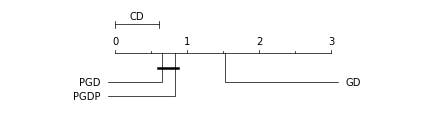

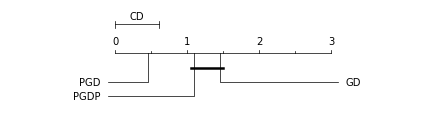

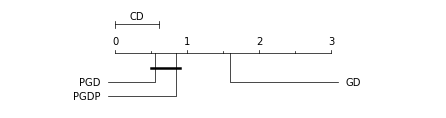

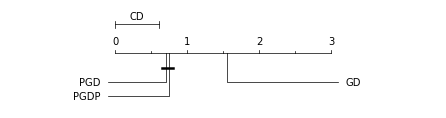

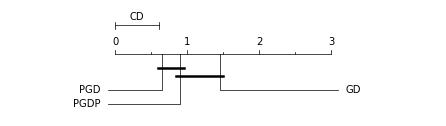

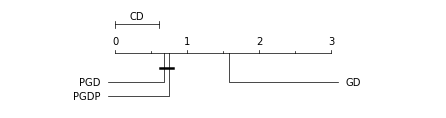

In [514]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
# block_list = ['th']
# block_list = ['qualified_nodes']
# block_list = ['strategy']
# block_list = ['embedding']
# block_list = ['graph_type']

embedding_types = ['Node2Vec', 'GCN']
group = 'qualified_nodes'

count = 0
for i in block_list:
    for j in embedding_types:
        count += 1
        if i != group and i!='embedding':
            print()
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
#                 run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
                run_friedman_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
#             run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
#             try:
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
#             except: 
#                 print('skip')

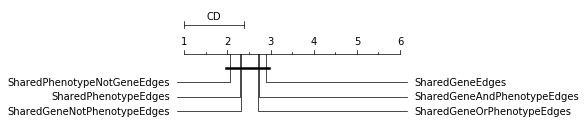

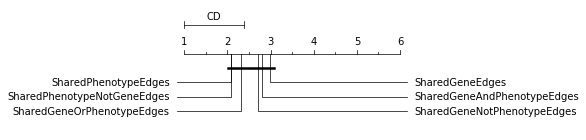

In [515]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'qualified_nodes']
embedding_types = ['Node2Vec', 'GCN']
group = 'embedding'

for i in block_list:
    if i != group:
        run_nemenyi_test(test_all_record_7, group, i )
            


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = th
--------for all----
stat=38.089, p=0.000
Probably different distributions
--------for bottom----
stat=41.378, p=0.000
Probably different distributions
--------for bottom_rand----
stat=38.311, p=0.000
Probably different distributions
--------for shared----
stat=35.156, p=0.000
Probably different distributions
--------for top----
stat=36.978, p=0.000
Probably different distributions
--------for top_bottom----
stat=35.022, p=0.000
Probably different distributions
--------for top_bottom_rand----
stat=34.017, p=0.000
Probably different distributions
--------for top_rand----
stat=38.978, p=0.000
Probably different distributions


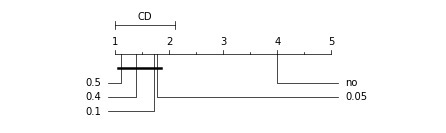

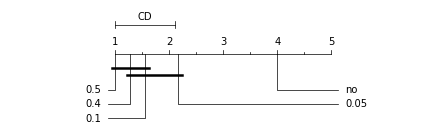

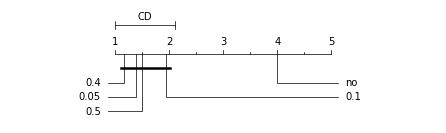

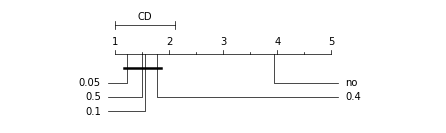

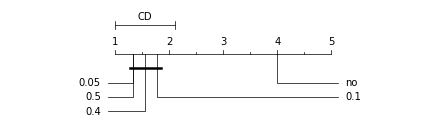

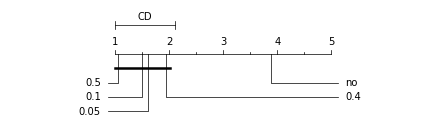

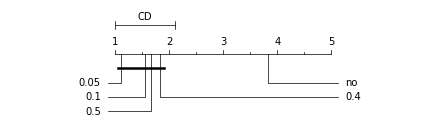

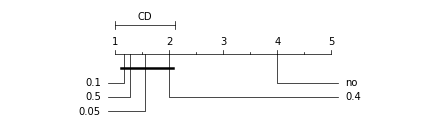


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = th
--------for all----
stat=27.600, p=0.000
Probably different distributions
--------for bottom----
stat=43.156, p=0.000
Probably different distributions
--------for bottom_rand----
stat=34.578, p=0.000
Probably different distributions
--------for shared----
stat=20.089, p=0.000
Probably different distributions
--------for top----
stat=25.911, p=0.000
Probably different distributions
--------for top_bottom----
stat=26.800, p=0.000
Probably different distributions
--------for top_bottom_rand----
stat=25.556, p=0.000
Probably different distributions
--------for top_rand----
stat=32.222, p=0.000
Probably different distributions


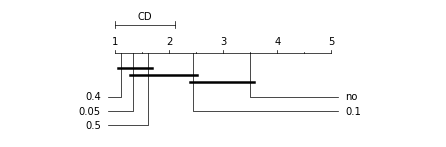

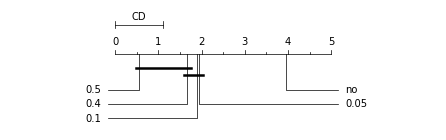

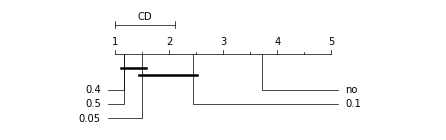

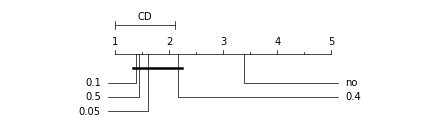

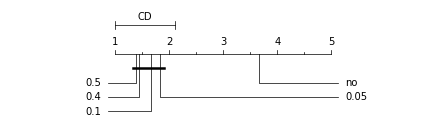

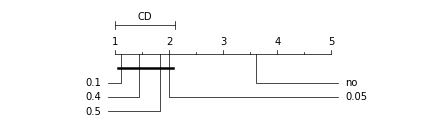

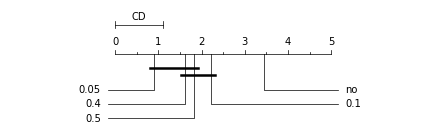

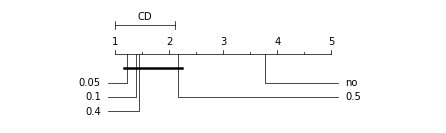


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = qualified_nodes
--------for all----
stat=4.881, p=0.431
Probably the same distribution
--------for bottom----
stat=1.000, p=0.963
Probably the same distribution
--------for bottom_rand----
stat=13.619, p=0.018
Probably different distributions
--------for shared----
stat=6.238, p=0.284
Probably the same distribution
--------for top----
stat=2.619, p=0.758
Probably the same distribution
--------for top_bottom----
stat=2.667, p=0.751
Probably the same distribution
--------for top_bottom_rand----
stat=8.190, p=0.146
Probably the same distribution
--------for top_rand----
stat=3.429, p=0.634
Probably the same distribution


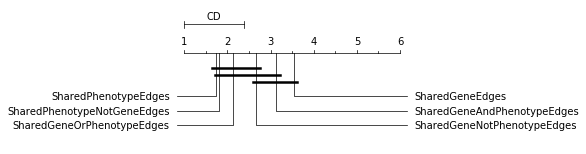

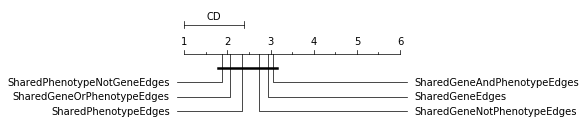

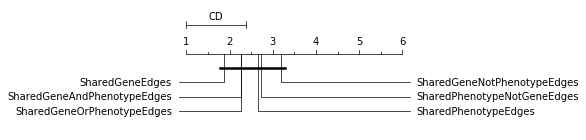

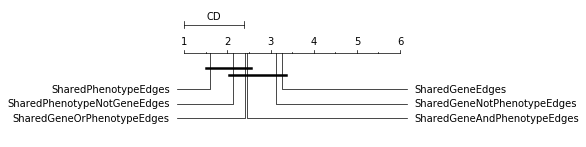

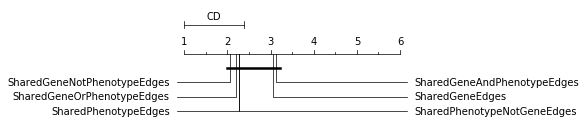

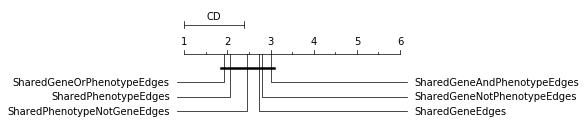

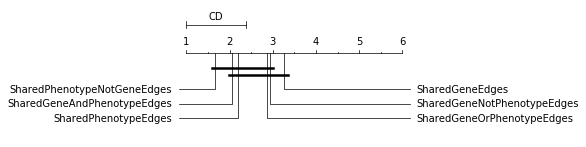

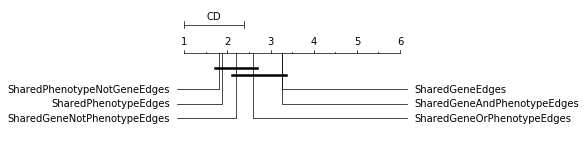


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = qualified_nodes
--------for all----
stat=3.000, p=0.700
Probably the same distribution
--------for bottom----
stat=13.476, p=0.019
Probably different distributions
--------for bottom_rand----
stat=10.810, p=0.055
Probably the same distribution
--------for shared----
stat=16.095, p=0.007
Probably different distributions
--------for top----
stat=4.333, p=0.502
Probably the same distribution
--------for top_bottom----
stat=9.048, p=0.107
Probably the same distribution
--------for top_bottom_rand----
stat=3.667, p=0.598
Probably the same distribution
--------for top_rand----
stat=11.762, p=0.038
Probably different distributions


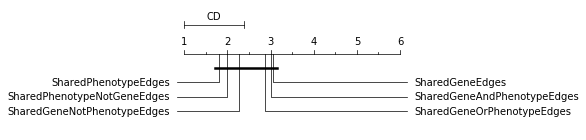

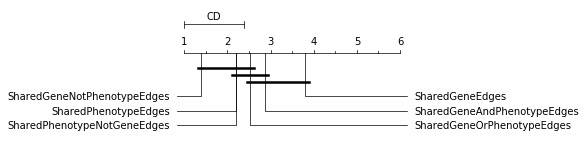

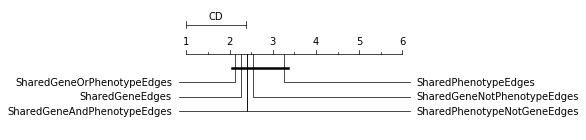

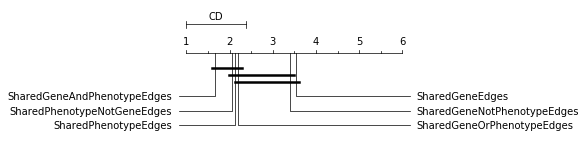

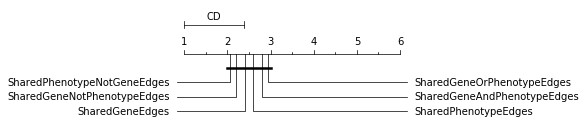

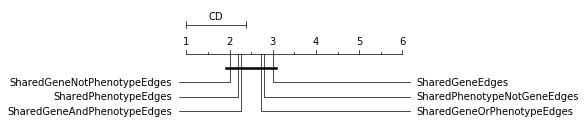

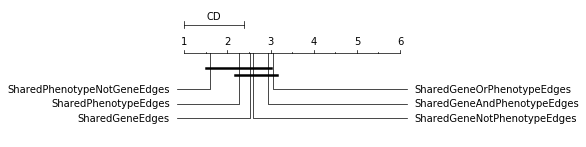

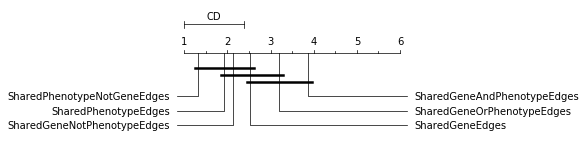


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = graph_type
--------for all----
stat=18.200, p=0.000
Probably different distributions
--------for bottom----
stat=2.067, p=0.356
Probably the same distribution
--------for bottom_rand----
stat=8.867, p=0.012
Probably different distributions
--------for shared----
stat=17.267, p=0.000
Probably different distributions
--------for top----
stat=11.467, p=0.003
Probably different distributions
--------for top_bottom----
stat=4.467, p=0.107
Probably the same distribution
--------for top_bottom_rand----
stat=2.600, p=0.273
Probably the same distribution
--------for top_rand----
stat=11.467, p=0.003
Probably different distributions


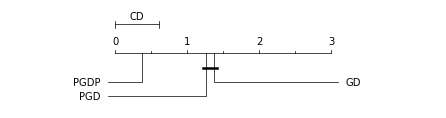

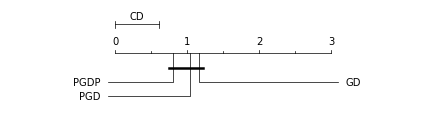

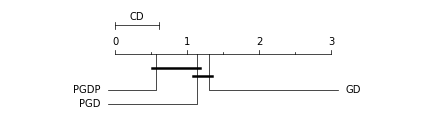

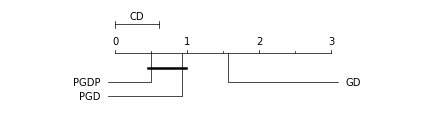

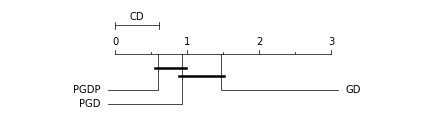

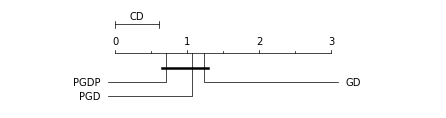

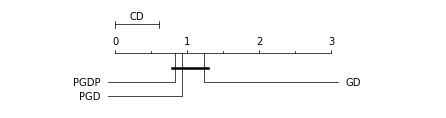

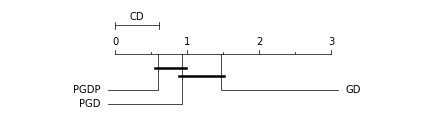


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = graph_type
--------for all----
stat=17.267, p=0.000
Probably different distributions
--------for bottom----
stat=9.600, p=0.008
Probably different distributions
--------for bottom_rand----
stat=12.600, p=0.002
Probably different distributions
--------for shared----
stat=9.800, p=0.007
Probably different distributions
--------for top----
stat=14.600, p=0.001
Probably different distributions
--------for top_bottom----
stat=11.267, p=0.004
Probably different distributions
--------for top_bottom_rand----
stat=21.067, p=0.000
Probably different distributions
--------for top_rand----
stat=14.467, p=0.001
Probably different distributions


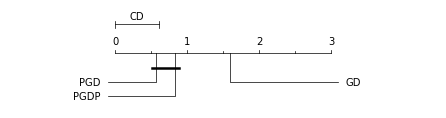

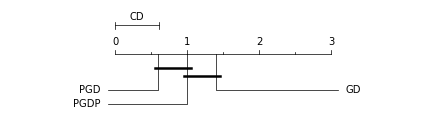

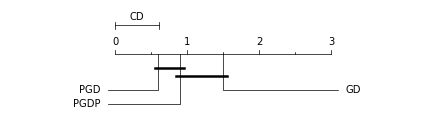

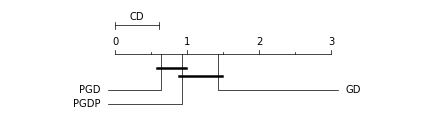

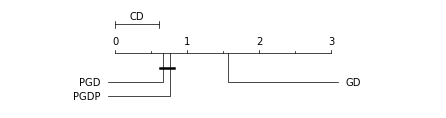

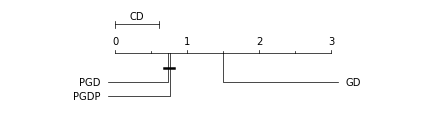

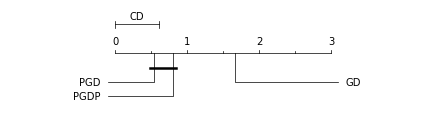

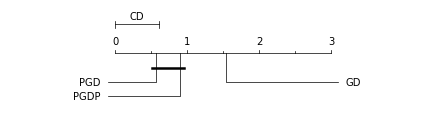

In [516]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
# block_list = ['th']
# block_list = ['qualified_nodes']
# block_list = ['strategy']
# block_list = ['embedding']
# block_list = ['graph_type']

embedding_types = ['Node2Vec', 'GCN']
group = 'strategy'

count = 0
for i in block_list:
    for j in embedding_types:
        count += 1
        if i != group and i!='embedding':
            print()
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
#                 run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
                run_friedman_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
#             run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
#             try:
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
#             except: 
#                 print('skip')

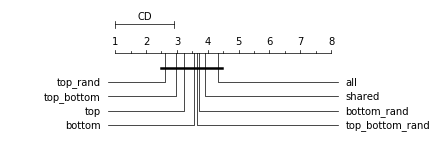

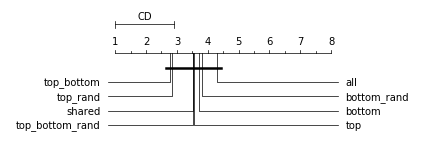

In [517]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'strategy']
embedding_types = ['Node2Vec', 'GCN']
group = 'embedding'

for i in block_list:
    if i != group:
        run_nemenyi_test(test_all_record_7, group, i )
            


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = th
--------for GD----
stat=96.533, p=0.000
Probably different distributions
--------for PGD----
stat=97.721, p=0.000
Probably different distributions
--------for PGDP----
stat=87.183, p=0.000
Probably different distributions


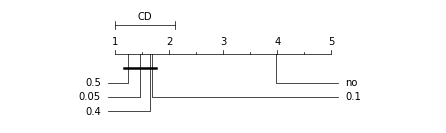

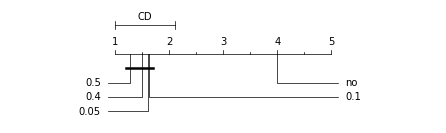

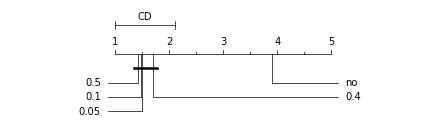


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = th
--------for GD----
stat=97.383, p=0.000
Probably different distributions
--------for PGD----
stat=45.950, p=0.000
Probably different distributions
--------for PGDP----
stat=66.117, p=0.000
Probably different distributions


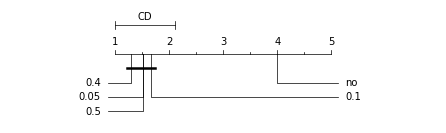

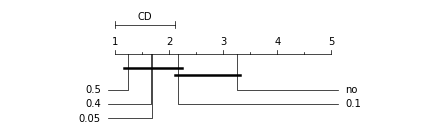

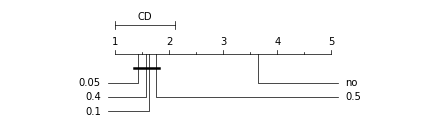


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = qualified_nodes
--------for GD----
stat=3.107, p=0.683
Probably the same distribution
--------for PGD----
stat=3.554, p=0.615
Probably the same distribution
--------for PGDP----
stat=4.964, p=0.420
Probably the same distribution


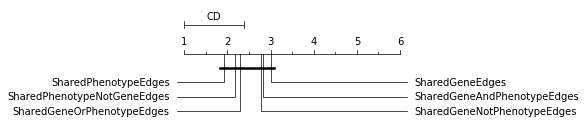

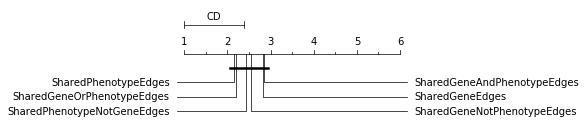

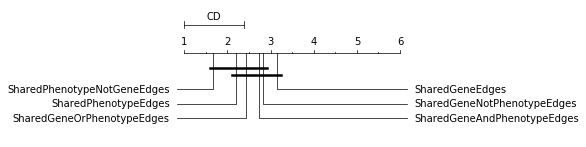


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = qualified_nodes
--------for GD----
stat=3.286, p=0.656
Probably the same distribution
--------for PGD----
stat=3.839, p=0.573
Probably the same distribution
--------for PGDP----
stat=10.625, p=0.059
Probably the same distribution


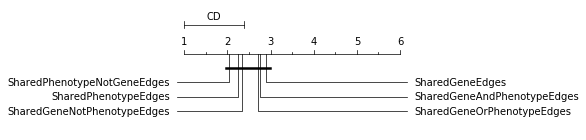

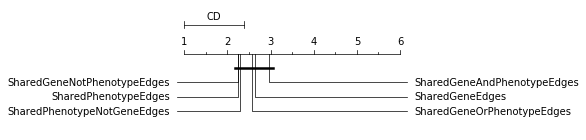

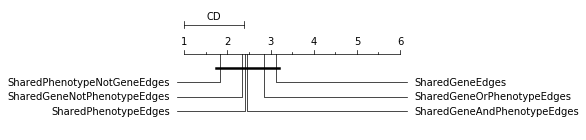


>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = strategy
--------for GD----
stat=3.764, p=0.807
Probably the same distribution
--------for PGD----
stat=4.722, p=0.694
Probably the same distribution
--------for PGDP----
stat=7.778, p=0.353
Probably the same distribution


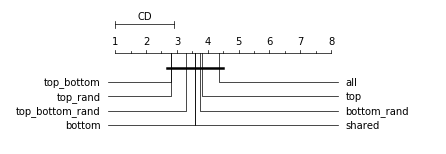

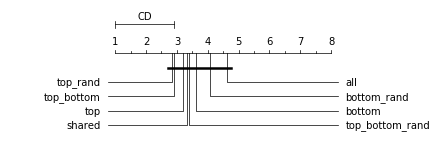

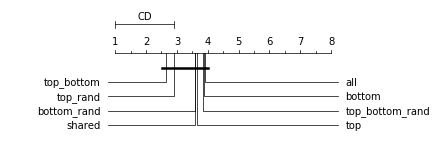


>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = strategy
--------for GD----
stat=13.000, p=0.072
Probably the same distribution
--------for PGD----
stat=5.097, p=0.648
Probably the same distribution
--------for PGDP----
stat=4.694, p=0.697
Probably the same distribution


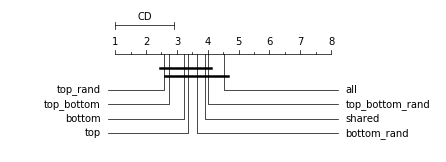

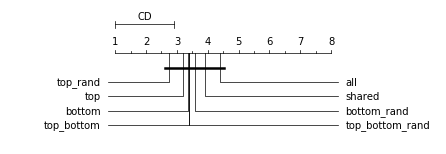

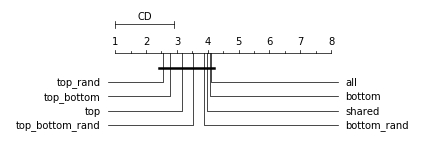

In [518]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
# block_list = ['th']
# block_list = ['qualified_nodes']
# block_list = ['strategy']
# block_list = ['embedding']
# block_list = ['graph_type']

embedding_types = ['Node2Vec', 'GCN']
group = 'graph_type'

count = 0
for i in block_list:
    for j in embedding_types:
        count += 1
        if i != group and i!='embedding':
            print()
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
#                 run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
                run_friedman_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
#             run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
#             try:
            run_nemenyi_test(test_all_record_7[test_all_record_7['embedding'] == j], group, i )
#             except: 
#                 print('skip')

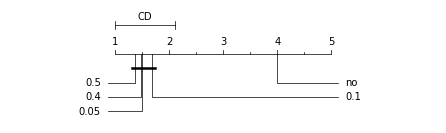

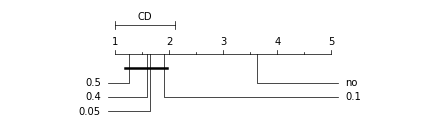

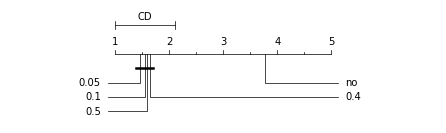

In [519]:
# block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'th']
embedding_types = ['Node2Vec', 'GCN']
group = 'graph_type'

for i in block_list:
    if i != group:
        run_nemenyi_test(test_all_record_7, group, i )
            

# Comparing GCN and Node2vec

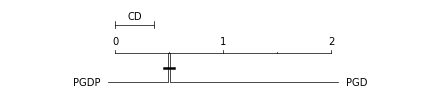

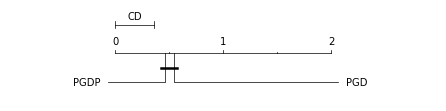

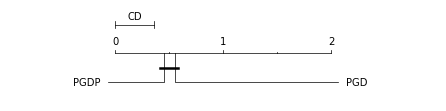

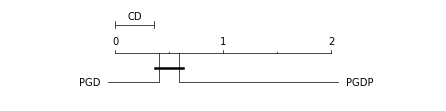

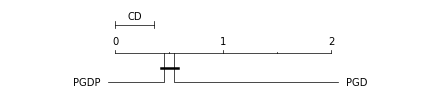

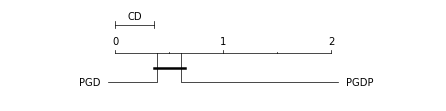

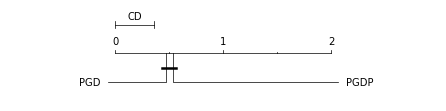

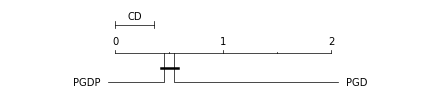

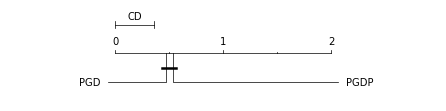

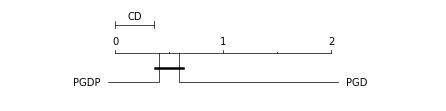

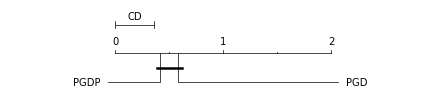

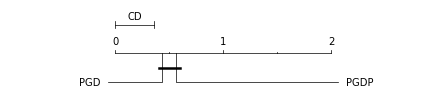

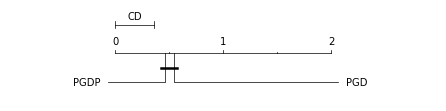

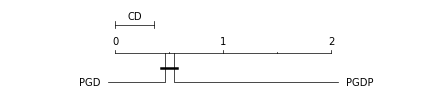

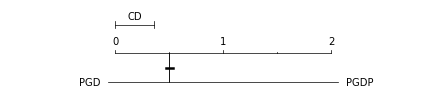

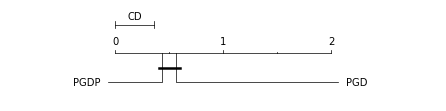

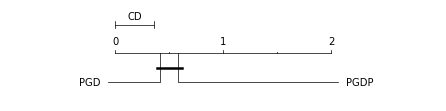

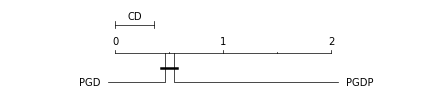

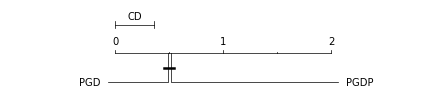

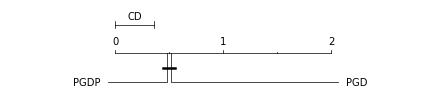

In [521]:
group = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'embedding']
# embedding_types = ['Node2Vec', 'GCN']


for i in block_list:
    for j in group:
        if i != j:
            run_nemenyi_test(test_all_record_2, j, i )
            

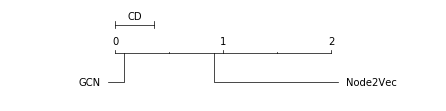

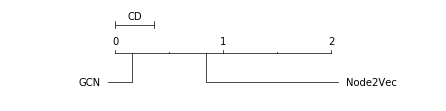

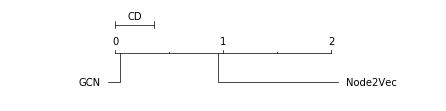

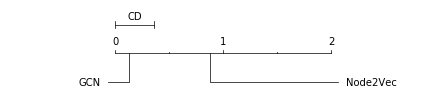

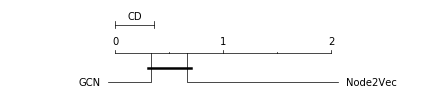

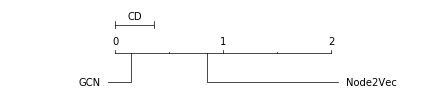

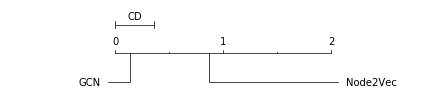

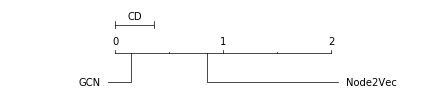

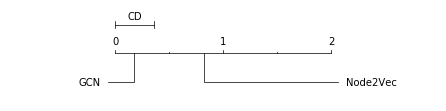

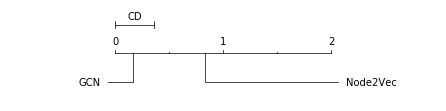

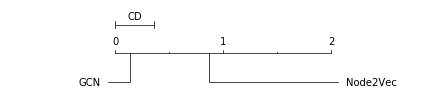

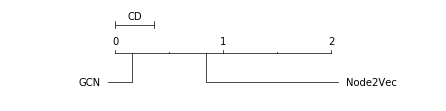

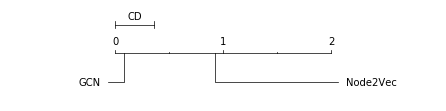

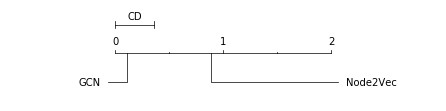

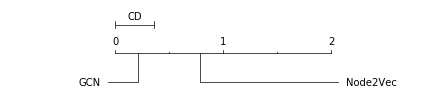

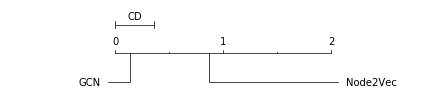

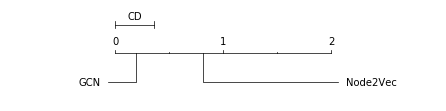

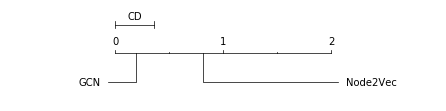

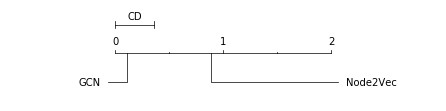

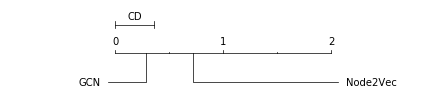

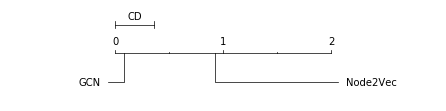

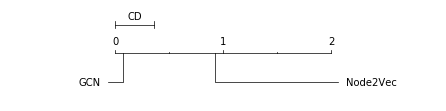

In [520]:
group = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']
block_list = [ 'embedding']
# embedding_types = ['Node2Vec', 'GCN']


for i in block_list:
    for j in group:
        if i != j:
            run_nemenyi_test(test_all_record_7, j, i )
            

# GCN vs Node2vec

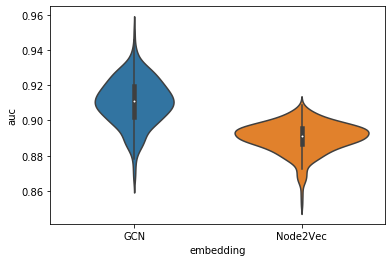

In [404]:
sns.violinplot(x='embedding', y='auc', data=test_all_record2)

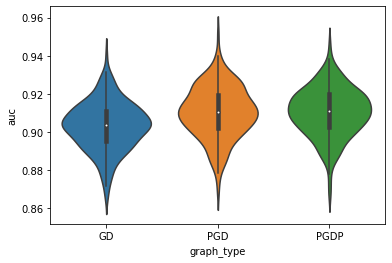

In [447]:
# ax = sns.violinplot(x='graph_type', y='auc', hue='th', data=test_all_record_8[test_all_record_8['embedding'] == 'Node2Vec'])
# ax = sns.violinplot(x='th', y='auc',data=tmp[tmp['embedding'] == 'GCN'])
ax = sns.violinplot(x='graph_type', y='auc',data=test_all_record_8[test_all_record_8['embedding']])



# Deviation from mean plot

# Box plot

                            GD


c:\users\anak\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


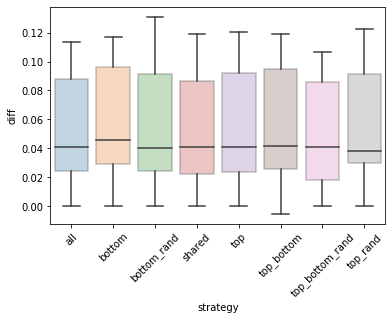

                            PGD


c:\users\anak\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


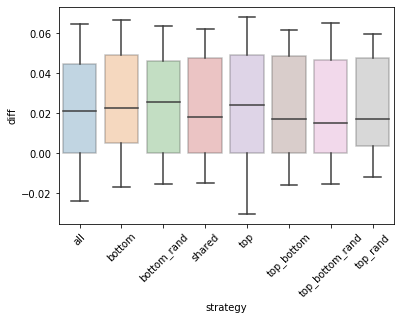

                            PGDP


c:\users\anak\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


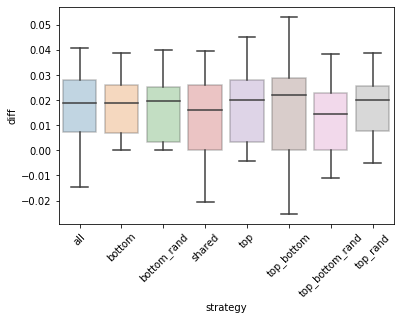

In [506]:
# tmp = deviation_df.groupby(['embedding','graph_type'])
tmp = deviation_df.groupby(['graph_type'])
# tmp = deviation_df.groupby(['embedding'])
# tmp = deviation_df.groupby(['qualified_nodes'])
for i,j in tmp:
    print(f'                            {i}')
    j['diff'] = j['diff'].astype(float)
#     ax = sns.violinplot(x='strategy', y='diff', hue='th', data=j)
#     ax = sns.violinplot(x='th', y='diff', data=j)
#     print(j)
    ax = sns.boxplot(x="strategy", y="diff",data=j, boxprops=dict(alpha=.3))
#     plt.plot(np.zeros(7), linewidth=2)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#     sns.despine(ax=b, left=True, bottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

    

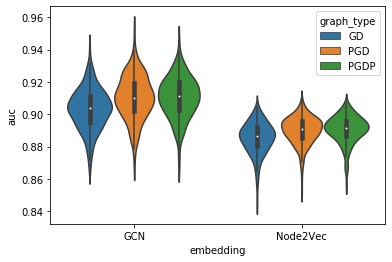

In [485]:
ax = sns.violinplot(x='embedding', y='auc' , hue='graph_type',data=test_all_record_8)

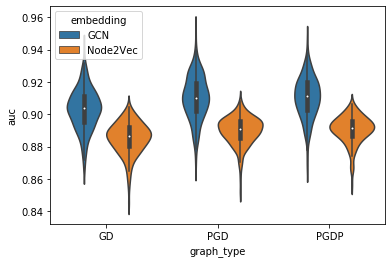

In [486]:
ax = sns.violinplot(x='graph_type', y='auc' , hue='embedding',data=test_all_record_8)